## Demonstration of the pipeline with the visualization of results

This code assumes that run.sh was run with the default values beforehand.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pickle, os, torch, cv2

from src.data_loading import loading
from src.modeling import glam as glam

### Step 1: prepare the data


In [2]:
with open("sample_data/data.pkl", "rb") as f:
    exam_list = pickle.load(f)
datum = exam_list[1]
view = "R-CC"
short_file_path = datum[view][0]


### Step 2: load the image


In [3]:
loaded_image = loading.load_image(
                    image_path=os.path.join("sample_data/cropped_images/1ca_1_L_CC.png"),
                    view=view, horizontal_flip=datum["horizontal_flip"])

#", short_file_path + ".png"),

In [4]:
print(short_file_path)

1_R-CC


### Step 3: preprocess the image


In [5]:
loaded_image = loading.process_image(loaded_image, view, datum["best_center"][view][0])


(2944, 1920)


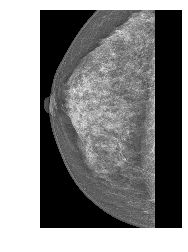

In [6]:
print(loaded_image.shape)
plt.imshow(loaded_image, cmap="Greys_r")
plt.axis("off")
plt.show()

### Step4: load the model

In [7]:
parameters = {
        "device_type":"cpu",
        "cam_size": (184,120), ###(184,120),
        "top_k_per_class": 1,
        "crop_shape": (512, 512),
        "percent_k":0.03,
        "detection_pooling_percent_k":0.3,
        "fusion": True
            
    
    }


In [8]:
model = glam.MILSingleImageModel(parameters)

In [9]:
model.load_state_dict(torch.load("models/model_joint.ckpt", map_location="cpu"), strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['mil.mil_attn_V.weight', 'mil.mil_attn_U.weight', 'mil.mil_attn_w.weight', 'mil.classifier_linear.weight', 'fusion_dnn.weight', 'fusion_dnn.bias', 'shared_rep_filter.weight'])

In [10]:
model

MILSingleImageModel(
  (global_network): GlobalNetworkGeneric(
    (downsampling_branch): DownSampleNetworkResNetV2(
      (first_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (first_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer_list): ModuleList(
        (0): Sequential(
          (0): BasicBlockV2(
            (relu): ReLU(inplace)
            (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (downsample): Sequential(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
          )
          (1): BasicBlockV2(
 

### Step 5:Inference 

In [11]:
tensor_batch = torch.Tensor(np.expand_dims(np.expand_dims(loaded_image, 0), 0).copy())
output = model(tensor_batch)
pred_numpy = output.data.cpu().numpy()
malignant_pred = pred_numpy[0, 1]

In [12]:
print("malignant prediction = {}".format(malignant_pred))

malignant prediction = 0.017523333430290222


### Step 6:visualizing the saliency map

The local module saliency map

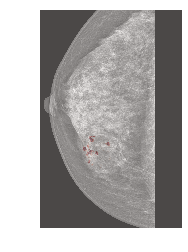

In [13]:
saliency_maps = model.saliency_map_local.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1.0])
plt.axis("off")
plt.show()

The global module saliency map

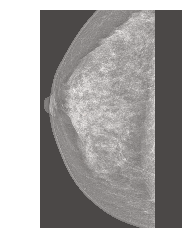

In [31]:
saliency_maps = model.saliency_map_global.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1.0])
plt.axis("off")
plt.show()

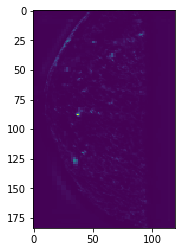

In [32]:
plt.imshow(malignant_saliency_map)
plt.show()

In [33]:
np.shape(malignant_saliency_map)

(184, 120)

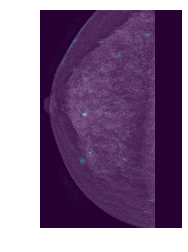

In [34]:
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.6)
plt.axis("off")
plt.show()

The combined saliency map

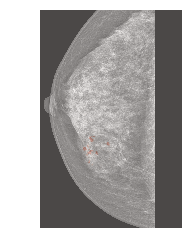

In [35]:
saliency_maps = model.saliency_map.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1])
plt.axis("off")
plt.show()


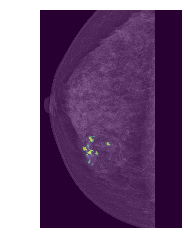

In [36]:
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.6)
plt.axis("off")
plt.show()